In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import dlib
import imutils
from imutils import face_utils
from scipy.spatial import distance as dist
from skimage import draw

%matplotlib inline
datadir = "data"

In [2]:
FACIAL_LANDMARK_PREDICTOR = "models/shape_predictor.dat"  
MINIMUM_EAR = 0.2
MAXIMUM_FRAME_COUNT = 10

In [3]:
faceDetector = dlib.get_frontal_face_detector()
landmarkFinder = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)

In [4]:
(leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

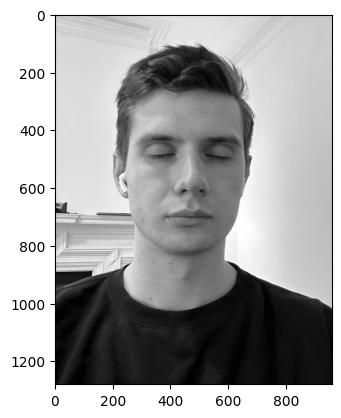

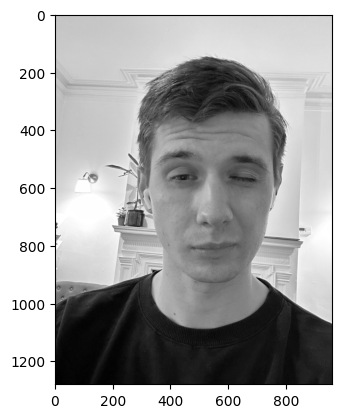

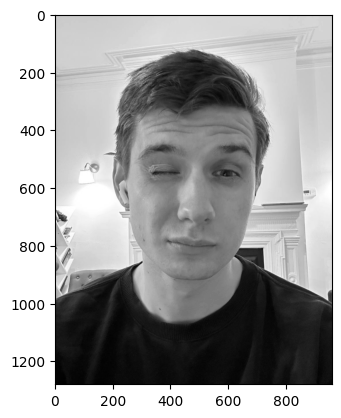

In [5]:
# For now assume the first image is always the target image.
imagePaths = ['/paired/3/bothclosed.jpeg', '/paired/3/leftclosed3.jpeg', '/paired/3/rightclosed2.jpeg']
images = []
for imagePath in imagePaths:
    image = cv2.cvtColor(cv2.imread(datadir+imagePath), cv2.COLOR_BGR2GRAY)
    plt.imshow(image, cmap="gray")
    plt.show()
    images.append(image)

In [6]:
# Supplementary functions.

# Compute EAR, a good indicator of whether an eye is open or closed. Source:
# Source: https://www.mdpi.com/2079-9292/11/19/3183.
# EAR = (|| P2 - P6 || + || P3 - P5 ||) / 2 * || P1 - P4 ||
def eye_aspect_ratio(eye):
    return (dist.euclidean(eye[1], eye[5]) + dist.euclidean(eye[2], eye[4])) / (2.0 * dist.euclidean(eye[0], eye[3]))

# Centroids are used to compute the target blending position.
def centroid(eye):
    return int(sum(eye[:, 0] / len(eye[:, ]))), int(sum(eye[:, 1] / len(eye[:, ])))

In [7]:
# Accept an image and locate the eyes within it. Compute eye coordinates and
# classify each eye as open or closed. Return two objects: the left eye and the
# right eye.
def get_eyes_from_image(image):
    faces = faceDetector(image, 0)
    # For now only support if and only if there is one face in the image.
    assert(len(faces) == 1)
    face_landmarks = landmarkFinder(image, faces[0])
    face_landmarks = face_utils.shape_to_np(face_landmarks)
    left_eye = face_landmarks[leftEyeStart:leftEyeEnd]
    right_eye = face_landmarks[rightEyeStart:rightEyeEnd]
    left_EAR = eye_aspect_ratio(left_eye)
    right_EAR = eye_aspect_ratio(right_eye)
    
    # need to make these more robust and also for centroids
    diff_left_1 = np.int32((face_landmarks[23] + face_landmarks[43]) / 2) - face_landmarks[43]
    diff_left_2 = np.int32((face_landmarks[24] + face_landmarks[44]) / 2) - face_landmarks[44]
    diff_left_3 = np.int32((face_landmarks[27] + face_landmarks[42]) / 2) - face_landmarks[42]
    diff_right_1 = np.int32((face_landmarks[19] + face_landmarks[37]) / 2) - face_landmarks[37]
    diff_right_2 = np.int32((face_landmarks[20] + face_landmarks[38]) / 2) - face_landmarks[38]
    diff_right_3 = np.int32((face_landmarks[27] + face_landmarks[39]) / 2) - face_landmarks[39]

    left_eye[0] += diff_left_3
    left_eye[1] += diff_left_1
    left_eye[2] += diff_left_2
    left_eye[3] -= diff_left_3
    left_eye[4] -= diff_left_2
    left_eye[5] -= diff_left_1
    
    right_eye[0] -= diff_right_3
    right_eye[1] += diff_right_1
    right_eye[2] += diff_right_2
    right_eye[3] += diff_right_3
    right_eye[4] -= diff_right_2
    right_eye[5] -= diff_right_1
    
    left_eye = {
        "kind": "left",
        "EAR": left_EAR,
        "status": "closed" if left_EAR < MINIMUM_EAR else "open",
        "centroid": centroid(left_eye),
        "coordinates": left_eye,
    }
    
    right_eye = {
        "kind": "right",
        "EAR": left_EAR,
        "status": "closed" if right_EAR < MINIMUM_EAR else "open",
        "centroid": centroid(right_eye),
        "coordinates": right_eye,
    }
    
    return left_eye, right_eye

In [8]:
# Let the user specify which image is target in the future.
target_image = images[0]
target_eyes = get_eyes_from_image(target_image)
source_images = images[1:]
source_eyes = [get_eyes_from_image(image) for image in source_images]
replacements = []

for i, target_eye in enumerate(target_eyes):
    if target_eye['status'] == 'open':
        continue
    
    max_source_EAR = -1
    source_eye = None
    source_image_index = -1
    for j, candidate_eyes in enumerate(source_eyes):
        candidate_eye = candidate_eyes[i]
        if candidate_eye['status'] == 'open' and candidate_eye['EAR'] > max_source_EAR:
            max_source_EAR = candidate_eye['EAR']
            source_eye = candidate_eye
            source_image_index = j
    
    if source_eye is None:
        # We have nothing to replace this particular eye with, continue.
        continue
    
    replacements.append({
        'target_eye': target_eye,
        'source_image_index': source_image_index,
        'source_eye': source_eye
    })

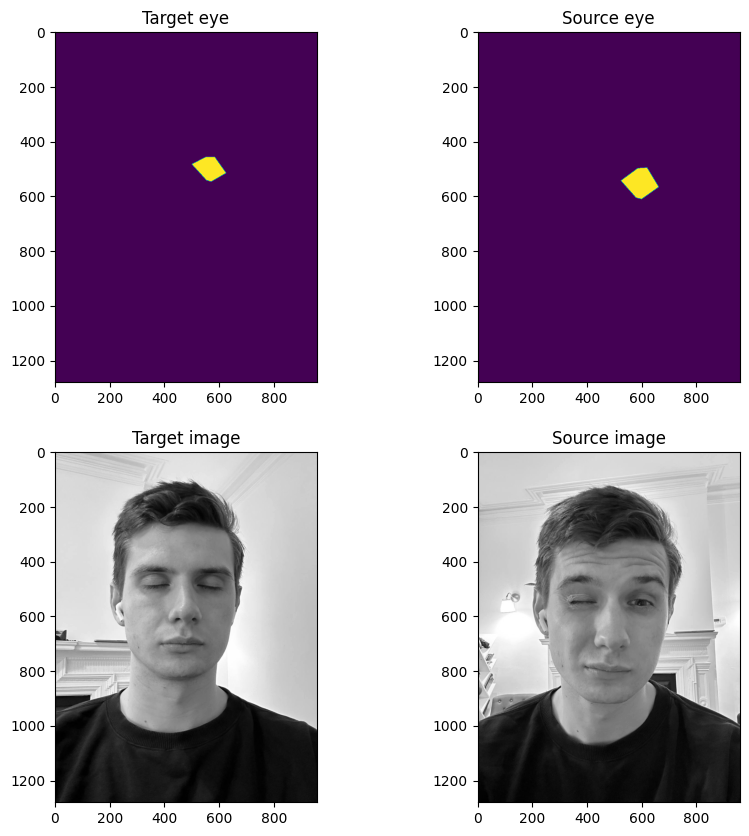

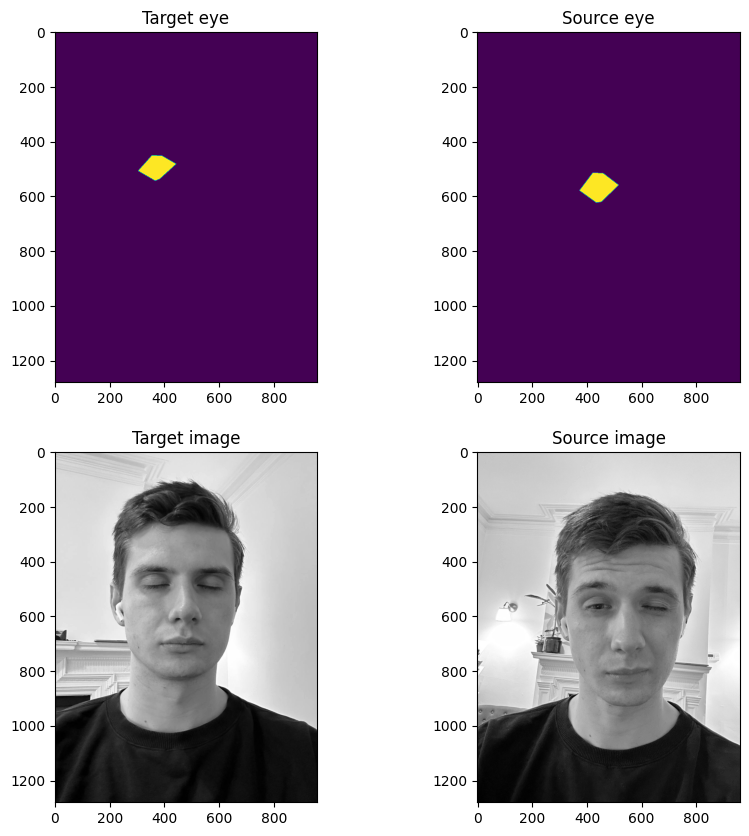

In [9]:
for replacement in replacements:
    fig = plt.figure(figsize=(10, 10))
    target_eye_mask = np.zeros(target_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(target_eye_mask, [replacement['target_eye']['coordinates']], color=255)
    plt.subplot(2, 2, 1)
    plt.title('Target eye')
    plt.imshow(target_eye_mask)
    
    plt.subplot(2, 2, 3)
    plt.title('Target image')
    plt.imshow(target_image, cmap="gray")
    
    source_eye_mask = np.zeros(source_images[replacement['source_image_index']].shape[:2], dtype=np.uint8) 
    cv2.fillPoly(source_eye_mask, [replacement['source_eye']['coordinates']], color=255)
    plt.subplot(2, 2, 2)
    plt.title('Source eye')
    plt.imshow(source_eye_mask)
    
    plt.subplot(2, 2, 4)
    plt.title('Source image')
    plt.imshow(source_images[replacement['source_image_index']], cmap="gray")
    
    plt.show()